In [ ]:
# Standard imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from datetime import datetime
import re
# NLP specific imports
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


# Download required NLTK data
nltk_resources = ['punkt', 'stopwords', 'wordnet', 'averaged_perceptron_tagger',
                 'maxent_ne_chunker', 'words']
for resource in nltk_resources:
    try:
        nltk.data.find(f'tokenizers/{resource}')
    except LookupError:
        nltk.download(resource)

# Initialize spaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    print("Downloading spaCy model...")
    os.system('python -m spacy download en_core_web_sm')
    nlp = spacy.load('en_core_web_sm')

print("✓ Environment setup completed successfully")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


✓ Environment setup completed successfully


## 1. Data Loading and Initial Exploration
Load the datasets and perform initial data analysis

In [ ]:
# Load the datasets
udemy_df = pd.read_csv('/content/udemy_courses.csv')
coursera_df = pd.read_csv('/content/Coursera.csv')

In [ ]:
print("Udemy Dataset Info:")
print(udemy_df.info())


Udemy Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3678 entries, 0 to 3677
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3678 non-null   int64  
 1   course_title         3678 non-null   object 
 2   url                  3678 non-null   object 
 3   is_paid              3678 non-null   bool   
 4   price                3678 non-null   int64  
 5   num_subscribers      3678 non-null   int64  
 6   num_reviews          3678 non-null   int64  
 7   num_lectures         3678 non-null   int64  
 8   level                3678 non-null   object 
 9   content_duration     3678 non-null   float64
 10  published_timestamp  3678 non-null   object 
 11  subject              3678 non-null   object 
dtypes: bool(1), float64(1), int64(5), object(5)
memory usage: 319.8+ KB
None


In [ ]:
print("\nCoursera Dataset Info:")
print(coursera_df.info())


Coursera Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Course Name         3522 non-null   object
 1   University          3522 non-null   object
 2   Difficulty Level    3522 non-null   object
 3   Course Rating       3522 non-null   object
 4   Course URL          3522 non-null   object
 5   Course Description  3522 non-null   object
 6   Skills              3522 non-null   object
dtypes: object(7)
memory usage: 192.7+ KB
None


In [ ]:
udemy_df.rename(columns={'course_title': 'Course Name', 'subject': 'Skills', 'level': 'Difficulty Level'}, inplace=True)

In [ ]:
udemy_df.columns

Index(['course_id', 'Course Name', 'url', 'is_paid', 'price',
       'num_subscribers', 'num_reviews', 'num_lectures', 'Difficulty Level',
       'content_duration', 'published_timestamp', 'Skills'],
      dtype='object')

In [ ]:
udemy_df['Description'] = udemy_df['Course Name'] + ' ' + udemy_df['Skills']
udemy_df['Description'] = udemy_df['Description'].str.replace('\n', ' ')

In [ ]:
#now combine both datasets
coursera_df.rename(columns={'Course Name': 'Course Name', 'Skills': 'Skills', 'Course Description': 'Description', 'Course URL': 'url'}, inplace=True)


In [ ]:

coursera_df['Skills'] = coursera_df['Skills'].str.split('  ')

udemy_df['Skills'] = udemy_df['Skills'].apply(lambda x: [x])

In [ ]:
# Now combine the datasets with the modified Skills columns
combined_df = pd.concat([udemy_df[['Course Name', 'Skills', 'Description', 'Difficulty Level', 'url']],
                        coursera_df[['Course Name', 'Skills', 'Description', 'Difficulty Level', 'url']]],
                        ignore_index=True)


In [ ]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7200 entries, 0 to 7199
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Course Name       7200 non-null   object
 1   Skills            7200 non-null   object
 2   Description       7200 non-null   object
 3   Difficulty Level  7200 non-null   object
 4   url               7200 non-null   object
dtypes: object(5)
memory usage: 281.4+ KB


In [ ]:
combined_df['Skills'].values

array([list(['Business Finance']), list(['Business Finance']),
       list(['Business Finance']), ...,
       list(['analytics', 'tableau software', 'Business Intelligence', 'Statistical Dispersion', 'software', 'Demand Forecasting', 'General Statistics', 'Data Analysis', 'measurement', 'analysis business business-essentials']),
       list(['Angular', 'Mechanical Design', 'fluid mechanics', 'Framing', '3d rig', 'molecular dynamics', 'classical mechanics', 'energy', 'lecture', 'robotics physical-science-and-engineering mechanical-engineering']),
       list(['bigtable', 'bigquery', 'SQL', 'Google Cloud Platform', 'role-based access control', 'Cloud Storage', 'Kubernetes', 'identity management', 'Cloud Computing', 'Cloud Platforms computer-science software-development'])],
      dtype=object)

In [ ]:
def clean_skills(skills):
    if isinstance(skills, list) and all(isinstance(x, str) for x in skills):
        return skills
    elif isinstance(skills, list) and len(skills) == 1 and isinstance(skills[0], str):
        return [skills[0].strip()]
    elif isinstance(skills, str):
        return [x.strip() for x in skills.split(',') ]
    return []

combined_df['Skills'] = combined_df['Skills'].apply(clean_skills)

print("Sample of cleaned Skills:")
print(combined_df['Skills'].tail())

Sample of cleaned Skills:
7195    [Databases, syntax, analysis, web, Data Visual...
7196    [retirement, Causality, career, history of the...
7197    [analytics, tableau software, Business Intelli...
7198    [Angular, Mechanical Design, fluid mechanics, ...
7199    [bigtable, bigquery, SQL, Google Cloud Platfor...
Name: Skills, dtype: object


In [ ]:
# Get unique skills across all courses
unique_skills = set()
for skills_list in combined_df['Skills']:
    unique_skills.update(skills_list)

print(f"\nTotal number of unique skills: {len(unique_skills)}")
print("\nSample of unique skills:")
print(list(unique_skills)[:])


Total number of unique skills: 8556

Sample of unique skills:
['', 'use error', 'Wildlife Conservation', 'endurance life-sciences basic-science', 'Data Manipulation', 'online research methods', 'comfort', 'Mathematics math-and-logic math-and-logic', 'unmanned aerial vehicle', 'Kubernetes', '360-degree video computer-science design-and-product', 'html business business-strategy', 'certificate authority', 'electronic health record', 'playful business business-essentials', 'criticism arts-and-humanities music-and-art', 'brand marketing', 'voting business leadership-and-management', 'Landscape Design', 'release management information-technology security', 'Leadership and Management life-sciences patient-care', 'text editors', 'dataflow', 'external financing', 'history of communication', 'symptoms life-sciences patient-care', 'health psychology life-sciences public-health', 'k-mer', 'general knowledge', 'Binomial Distribution', 'mental health professional', 'mindfulness life-sciences psych

In [ ]:
combined_df.head()

,Course Name,Skills,Description,Difficulty Level,url
0,Ultimate Investment Banking Course,[Business Finance],Ultimate Investment Banking Course Business Fi...,All Levels,https://www.udemy.com/ultimate-investment-bank...
1,Complete GST Course & Certification - Grow You...,[Business Finance],Complete GST Course & Certification - Grow You...,All Levels,https://www.udemy.com/goods-and-services-tax/
2,Financial Modeling for Business Analysts and C...,[Business Finance],Financial Modeling for Business Analysts and C...,Intermediate Level,https://www.udemy.com/financial-modeling-for-b...
3,Beginner to Pro - Financial Analysis in Excel ...,[Business Finance],Beginner to Pro - Financial Analysis in Excel ...,All Levels,https://www.udemy.com/complete-excel-finance-c...
4,How To Maximize Your Profits Trading Options,[Business Finance],How To Maximize Your Profits Trading Options B...,Intermediate Level,https://www.udemy.com/how-to-maximize-your-pro...


In [ ]:
# Clean and standardize text columns
def clean_text(text):
    if pd.isna(text):
        return ''
    return re.sub(r'\s+', ',', text.strip()).replace(':','').replace(',,',',')

# Clean all relevant columns
combined_df['Course Name'] = combined_df['Course Name'].apply(clean_text)
combined_df['Description'] = combined_df['Description'].apply(clean_text)

# Handle Skills column separately since it's a list
combined_df['Skills'] = combined_df['Skills'].apply(lambda x: ','.join(x) if isinstance(x, list) else str(x))
combined_df['Skills'] = combined_df['Skills'].apply(clean_text)

In [ ]:
combined_df.head()

,Course Name,Skills,Description,Difficulty Level,url
0,"Ultimate,Investment,Banking,Course","Business,Finance","Ultimate,Investment,Banking,Course,Business,Fi...",All Levels,https://www.udemy.com/ultimate-investment-bank...
1,"Complete,GST,Course,&,Certification,-,Grow,You...","Business,Finance","Complete,GST,Course,&,Certification,-,Grow,You...",All Levels,https://www.udemy.com/goods-and-services-tax/
2,"Financial,Modeling,for,Business,Analysts,and,C...","Business,Finance","Financial,Modeling,for,Business,Analysts,and,C...",Intermediate Level,https://www.udemy.com/financial-modeling-for-b...
3,"Beginner,to,Pro,-,Financial,Analysis,in,Excel,...","Business,Finance","Beginner,to,Pro,-,Financial,Analysis,in,Excel,...",All Levels,https://www.udemy.com/complete-excel-finance-c...
4,"How,To,Maximize,Your,Profits,Trading,Options","Business,Finance","How,To,Maximize,Your,Profits,Trading,Options,B...",Intermediate Level,https://www.udemy.com/how-to-maximize-your-pro...


In [ ]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english')

# Create TF-IDF vectors for course descriptions
tfidf_matrix = tfidf.fit_transform(combined_df['Description'])

# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a Series with course indices
indices = pd.Series(combined_df.index, index=combined_df['Course Name']).drop_duplicates()

In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    """Get course recommendations based on course title

    Args:
        title (str): Title of the course
        cosine_sim (np.array): Cosine similarity matrix

    Returns:
        pd.DataFrame: Top 10 recommended courses with similarity scores
    """
    # Get the index of the course that matches the title
    idx = indices[title]

    # Get similarity scores for all courses
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort courses based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get top 10 most similar courses (excluding the input course)
    sim_scores = sim_scores[1:11]

    # Get course indices
    course_indices = [i[0] for i in sim_scores]

    # Return DataFrame with recommended courses
    recommendations = combined_df.iloc[course_indices][['Course Name', 'Description', 'Skills', 'Difficulty Level', 'url']].copy()
    recommendations['Similarity Score'] = [i[1] for i in sim_scores]

    return recommendations

# Test the Recommendation System
Let's test our recommendation system with a sample course

In [ ]:
# Test with a sample course
sample_course = combined_df['Course Name'].iloc[0]
print("Getting recommendations for:", sample_course)
recommendations = get_recommendations(sample_course)
print("\nTop 10 Recommended Courses:")
recommendations

Getting recommendations for: Ultimate,Investment,Banking,Course

Top 10 Recommended Courses:


,Course Name,Description,Skills,Difficulty Level,url,Similarity Score
39,"The,Complete,Investment,Banking,Course,2017","The,Complete,Investment,Banking,Course,2017,Bu...","Business,Finance",All Levels,https://www.udemy.com/the-complete-investment-...,0.686128
240,"Advanced,Accounting,for,Investment,Banking","Advanced,Accounting,for,Investment,Banking,Bus...","Business,Finance",Intermediate Level,https://www.udemy.com/advanced-accounting-for-...,0.681669
417,"The,Investment,Banking,Recruitment,Series","The,Investment,Banking,Recruitment,Series,Busi...","Business,Finance",All Levels,https://www.udemy.com/investmentbanking/,0.596879
418,"Business,Banking,101","Business,Banking,101,Business,Finance","Business,Finance",All Levels,https://www.udemy.com/business-banking-101/,0.539811
722,"Investment,Banking,Operations,Securities,Trade...","Investment,Banking,Operations,Securities,Trade...","Business,Finance",All Levels,https://www.udemy.com/investment-banking-opera...,0.491588
528,"Accounting,Finance,and,Banking,-,A,Comprehensi...","Accounting,Finance,and,Banking,-,A,Comprehensi...","Business,Finance",All Levels,https://www.udemy.com/accounting-finance-and-b...,0.480488
227,"Investment,Banking,How,to,Land,a,Job,on,Wall,S...","Investment,Banking,How,to,Land,a,Job,on,Wall,S...","Business,Finance",All Levels,https://www.udemy.com/how-to-land-a-job-on-wal...,0.459004
137,"Intro,to,Investment,Banking,M&A,IPO,Modeling,+...","Intro,to,Investment,Banking,M&A,IPO,Modeling,+...","Business,Finance",All Levels,https://www.udemy.com/investment-banking-merge...,0.458786
657,"Financial,Accounting,-,The,Ultimate,Beginner,C...","Financial,Accounting,-,The,Ultimate,Beginner,C...","Business,Finance",Beginner Level,https://www.udemy.com/financial-accounting-the...,0.440169
889,"Workshop,on,Banking,Credit,Analysis,Process","Workshop,on,Banking,Credit,Analysis,Process,Bu...","Business,Finance",All Levels,https://www.udemy.com/workshop-on-banking-cred...,0.411865


# Enhance Recommendations with Skills
Let's create a hybrid recommendation system that considers both course description and skills

In [ ]:
# Create TF-IDF vectors for skills
tfidf_skills = TfidfVectorizer(stop_words='english')
tfidf_skills_matrix = tfidf_skills.fit_transform(combined_df['Skills'])

# Calculate cosine similarity for skills
cosine_sim_skills = cosine_similarity(tfidf_skills_matrix, tfidf_skills_matrix)

# Create hybrid similarity matrix (70% description, 30% skills)
hybrid_sim = (0.7 * cosine_sim) + (0.3 * cosine_sim_skills)

In [ ]:
def get_hybrid_recommendations(title, cosine_sim=hybrid_sim):
    """Get course recommendations based on both description and skills

    Args:
        title (str): Title of the course
        cosine_sim (np.array): Hybrid similarity matrix

    Returns:
        pd.DataFrame: Top 10 recommended courses with similarity scores
    """
    # Get recommendations using the hybrid similarity matrix
    return get_recommendations(title, cosine_sim)

# Test hybrid recommendations
print("Getting hybrid recommendations for:", sample_course)
hybrid_recommendations = get_hybrid_recommendations(sample_course)
print("\nTop 10 Recommended Courses (Hybrid):")
hybrid_recommendations

Getting hybrid recommendations for: Ultimate,Investment,Banking,Course

Top 10 Recommended Courses (Hybrid):


,Course Name,Description,Skills,Difficulty Level,url,Similarity Score
39,"The,Complete,Investment,Banking,Course,2017","The,Complete,Investment,Banking,Course,2017,Bu...","Business,Finance",All Levels,https://www.udemy.com/the-complete-investment-...,0.780290
240,"Advanced,Accounting,for,Investment,Banking","Advanced,Accounting,for,Investment,Banking,Bus...","Business,Finance",Intermediate Level,https://www.udemy.com/advanced-accounting-for-...,0.777168
417,"The,Investment,Banking,Recruitment,Series","The,Investment,Banking,Recruitment,Series,Busi...","Business,Finance",All Levels,https://www.udemy.com/investmentbanking/,0.717816
418,"Business,Banking,101","Business,Banking,101,Business,Finance","Business,Finance",All Levels,https://www.udemy.com/business-banking-101/,0.677868
722,"Investment,Banking,Operations,Securities,Trade...","Investment,Banking,Operations,Securities,Trade...","Business,Finance",All Levels,https://www.udemy.com/investment-banking-opera...,0.644112
528,"Accounting,Finance,and,Banking,-,A,Comprehensi...","Accounting,Finance,and,Banking,-,A,Comprehensi...","Business,Finance",All Levels,https://www.udemy.com/accounting-finance-and-b...,0.636342
227,"Investment,Banking,How,to,Land,a,Job,on,Wall,S...","Investment,Banking,How,to,Land,a,Job,on,Wall,S...","Business,Finance",All Levels,https://www.udemy.com/how-to-land-a-job-on-wal...,0.621303
137,"Intro,to,Investment,Banking,M&A,IPO,Modeling,+...","Intro,to,Investment,Banking,M&A,IPO,Modeling,+...","Business,Finance",All Levels,https://www.udemy.com/investment-banking-merge...,0.621150
657,"Financial,Accounting,-,The,Ultimate,Beginner,C...","Financial,Accounting,-,The,Ultimate,Beginner,C...","Business,Finance",Beginner Level,https://www.udemy.com/financial-accounting-the...,0.608118
889,"Workshop,on,Banking,Credit,Analysis,Process","Workshop,on,Banking,Credit,Analysis,Process,Bu...","Business,Finance",All Levels,https://www.udemy.com/workshop-on-banking-cred...,0.588305


# Recommendation System by Difficulty Level
Let's create a function that filters recommendations by difficulty level

In [ ]:
def get_recommendations_by_level(title, difficulty_level=None, cosine_sim=hybrid_sim):
    """Get course recommendations filtered by difficulty level

    Args:
        title (str): Title of the course
        difficulty_level (str, optional): Desired difficulty level
        cosine_sim (np.array): Similarity matrix

    Returns:
        pd.DataFrame: Filtered recommendations
    """
    # Get initial recommendations
    recommendations = get_recommendations(title, cosine_sim)

    # Filter by difficulty level if specified
    if difficulty_level:
        recommendations = recommendations[recommendations['Difficulty Level'] == difficulty_level]

    return recommendations

# Test recommendations by difficulty level
beginner_recommendations = get_recommendations_by_level(sample_course, 'Beginner Level')
print("\nTop Beginner-Level Recommended Courses:")
beginner_recommendations


Top Beginner-Level Recommended Courses:


,Course Name,Description,Skills,Difficulty Level,url,Similarity Score
657,"Financial,Accounting,-,The,Ultimate,Beginner,C...","Financial,Accounting,-,The,Ultimate,Beginner,C...","Business,Finance",Beginner Level,https://www.udemy.com/financial-accounting-the...,0.608118


# Analyze Recommendation Quality
Let's visualize the similarity score distributions and evaluate our recommendation system

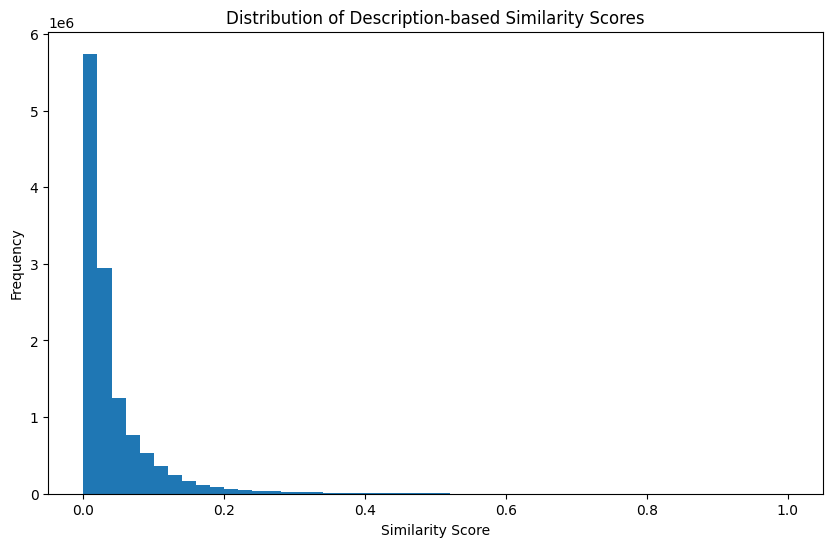

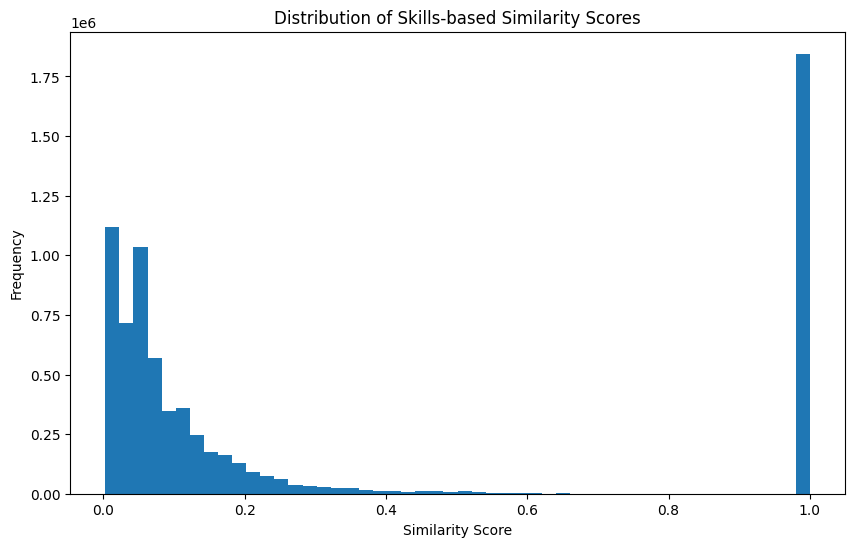

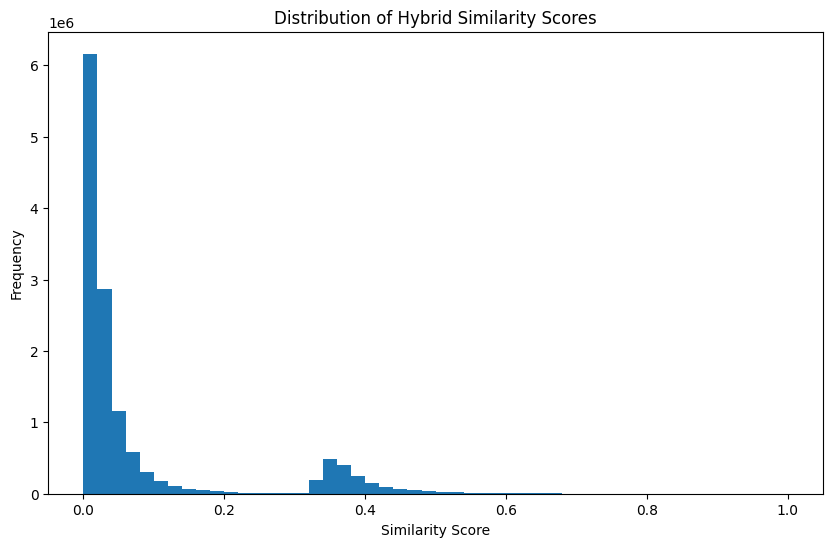

In [ ]:
def plot_similarity_distribution(sim_matrix, title):
    """Plot the distribution of similarity scores"""
    # Get upper triangle of similarity matrix
    upper_tri = np.triu(sim_matrix, k=1).flatten()
    # Remove zeros
    similarities = upper_tri[upper_tri != 0]

    plt.figure(figsize=(10, 6))
    plt.hist(similarities, bins=50)
    plt.title(f'Distribution of {title} Similarity Scores')
    plt.xlabel('Similarity Score')
    plt.ylabel('Frequency')
    plt.show()

# Plot distributions
plot_similarity_distribution(cosine_sim, 'Description-based')
plot_similarity_distribution(cosine_sim_skills, 'Skills-based')
plot_similarity_distribution(hybrid_sim, 'Hybrid')

In [ ]:
def find_courses_by_skills(skills, top_n=5):
    """Find courses that match given skills

    Args:
        skills (list): List of skills to search for
        top_n (int): Number of courses to return

    Returns:
        pd.DataFrame: Matching courses with their skills
    """
    # Convert skills to lowercase for case-insensitive matching
    skills = [skill.lower() for skill in skills]

    # Calculate skill match scores
    def calculate_skill_match(course_skills):
        course_skills = [s.lower() for s in course_skills.split(',')]
        return len(set(skills) & set(course_skills)) / len(skills)

    # Calculate match scores for all courses
    match_scores = combined_df['Skills'].apply(calculate_skill_match)

    # Get top matching courses
    top_matches = combined_df.iloc[match_scores.nlargest(top_n).index]
    top_matches['Skill Match Score'] = match_scores[top_matches.index]

    return top_matches[['Course Name', 'Skills', 'Difficulty Level', 'url', 'Skill Match Score']]

# Test skill-based search
sample_skills = ['python', 'machine learning', 'data analysis']
print("Finding courses matching skills:", sample_skills)
skill_matches = find_courses_by_skills(sample_skills)
skill_matches

Finding courses matching skills: ['python', 'machine learning', 'data analysis']


<ipython-input-27-9988a93bc5f7>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_matches['Skill Match Score'] = match_scores[top_matches.index]


,Course Name,Skills,Difficulty Level,url,Skill Match Score
3694,"Python,Programming,Essentials","semantics,Python,Programming,coding,convention...",Beginner,https://www.coursera.org/learn/python-programming,0.333333
3718,"Real-time,OCR,and,Text,Detection,with,Tensorfl...","image,processing,openbsd,optical,character,rec...",Beginner,https://www.coursera.org/learn/ocr-text-detect...,0.333333
3740,"Python,Tricks,and,Hacks,for,Productivity","Computer,Programming,Transpose,concision,Pytho...",Advanced,https://www.coursera.org/learn/python-hacks,0.333333
3765,"Build,Random,Forests,in,R,with,Azure,ML,Studio","forest,Writing,Random,Forest,evaluation,Machin...",Beginner,https://www.coursera.org/learn/azure-machine-l...,0.333333
3793,"Exception,Handling,in,Python","Python,Programming,exception,handling,relative...",Beginner,https://www.coursera.org/learn/exception-handl...,0.333333


In [ ]:
def get_course_clusters(n_clusters=5):
    """Cluster courses based on their TF-IDF vectors

    Args:
        n_clusters (int): Number of clusters to create

    Returns:
        pd.DataFrame: Courses with their cluster assignments
    """
    from sklearn.cluster import KMeans

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(tfidf_matrix)

    # Add cluster assignments to dataframe
    clustered_df = combined_df.copy()
    clustered_df['Cluster'] = clusters

    # Get most common skills in each cluster
    def get_cluster_skills(cluster_idx):
        cluster_courses = clustered_df[clustered_df['Cluster'] == cluster_idx]
        all_skills = [skill for skills in cluster_courses['Skills'].str.split(',') for skill in skills]
        return pd.Series(all_skills).value_counts().head(5).index.tolist()

    # Print cluster summaries
    for i in range(n_clusters):
        print(f"\nCluster {i} Top Skills:")
        print(get_cluster_skills(i))

    return clustered_df

# Create course clusters
clustered_courses = get_course_clusters()
print("\nSample courses from each cluster:")
print(clustered_courses.groupby('Cluster').head(1)[['Course Name', 'Cluster']])


Cluster 0 Top Skills:
['Web', 'Development', 'web', 'CSS', 'computer-science']

Cluster 1 Top Skills:
['project', 'Programming', 'Learning', 'data-science', 'Machine']

Cluster 2 Top Skills:
['Finance', 'Business', 'finance', 'business', 'financial']

Cluster 3 Top Skills:
['business', 'Management', 'and', 'analysis', 'computer-science']

Cluster 4 Top Skills:
['Instruments', 'Musical', 'Design', 'Graphic', 'design']

Sample courses from each cluster:
                                            Course Name  Cluster
0                    Ultimate,Investment,Banking,Course        2
291   Multiply,your,returns,using,'Value,Investing",...        3
1195           Anatomy,and,Figure,Drawing,for,Beginners        4
2478  Learn,Web,Designing,&,HTML5/CSS3,Essentials,in...        0
3682       Retrieve,Data,using,Single-Table,SQL,Queries        1


# Enhanced Text Processing and Feature Extraction
Let's implement better text processing and feature extraction for improved recommendations

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import re
from collections import Counter

# Download spaCy model
!python -m spacy download en_core_web_sm

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 94.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
def preprocess_text(text):
    """Advanced text preprocessing using spaCy

    Args:
        text (str): Input text

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ''

    # Convert to string if not already
    text = str(text)

    # Process with spaCy
    doc = nlp(text.lower())

    # Remove stopwords, punctuation and get lemmatized tokens
    tokens = [token.lemma_ for token in doc
             if not token.is_stop
             and not token.is_punct
             and token.lemma_ != '-PRON-']

    return ' '.join(tokens)

# Apply preprocessing to text columns
combined_df['processed_description'] = combined_df['Description'].apply(preprocess_text)
combined_df['processed_name'] = combined_df['Course Name'].apply(preprocess_text)
combined_df['processed_skills'] = combined_df['Skills'].apply(preprocess_text)

In [ ]:
def extract_features(df):
    """Extract features from course data

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        sparse matrix: TF-IDF features
    """
    # Combine processed text fields with different weights
    df['combined_features'] = (
        df['processed_name'] * 2 + ' ' +  # Higher weight for course name
        df['processed_description'] + ' ' +
        df['processed_skills'] * 3  # Higher weight for skills
    )

    # Create TF-IDF vectors
    tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),  # Include bigrams
        stop_words='english'
    )

    return tfidf.fit_transform(df['combined_features']), tfidf

# Extract features
tfidf_matrix, tfidf_vectorizer = extract_features(combined_df)

In [ ]:
def get_skill_recommendations(skill_name, user_proficiency='Beginner', top_n=5):
    """Get course recommendations based on skill and user proficiency

    Args:
        skill_name (str): Name of the skill
        user_proficiency (str): User's proficiency level (Beginner/Intermediate/Advanced)
        top_n (int): Number of recommendations to return

    Returns:
        pd.DataFrame: Top course recommendations
    """
    # Process the skill query
    processed_skill = preprocess_text(skill_name)

    # Transform the query into TF-IDF space
    skill_vector = tfidf_vectorizer.transform([processed_skill])

    # Calculate similarity scores
    similarity_scores = cosine_similarity(skill_vector, tfidf_matrix).flatten()

    # Create DataFrame with similarity scores
    scores_df = pd.DataFrame({
        'index': range(len(similarity_scores)),
        'similarity': similarity_scores
    })

    # Filter by user proficiency level
    if user_proficiency == 'Beginner':
        difficulty_levels = ['Beginner', 'Beginner Level', 'All Levels']
    elif user_proficiency == 'Intermediate':
        difficulty_levels = ['Intermediate', 'Intermediate Level', 'All Levels']
    else:
        difficulty_levels = ['Advanced', 'Expert Level', 'All Levels']

    filtered_indices = combined_df[combined_df['Difficulty Level'].isin(difficulty_levels)].index
    scores_df = scores_df[scores_df['index'].isin(filtered_indices)]

    # Get top recommendations
    top_indices = scores_df.nlargest(top_n, 'similarity')['index']
    recommendations = combined_df.iloc[top_indices][[
        'Course Name', 'Skills', 'Difficulty Level', 'url'
    ]].copy()

    # Add similarity scores
    recommendations['Relevance Score'] = scores_df.loc[top_indices, 'similarity'].values

    return recommendations.sort_values('Relevance Score', ascending=False)

# Example usage
print("Example recommendation for 'data science' (Beginner level):")
recommendations = get_skill_recommendations('data science', 'Beginner')
recommendations

Example recommendation for 'data science' (Beginner level):


,Course Name,Skills,Difficulty Level,url,Relevance Score
5441,"Geo-Visualization,in,Python","Map,Geovisualization,Data,Science,PyTorch,proj...",Beginner,https://www.coursera.org/learn/geo-visualizati...,0.372318
6508,"Genomic,Data,Science,with,Galaxy","rna-seq,Data,Analysis,Biostatistics,molecular,...",Beginner,https://www.coursera.org/learn/galaxy-project,0.341346
4285,"Data,Science,Ethics","Social,Media,informed,consent,privacy,relative...",Beginner,https://www.coursera.org/learn/data-science-et...,0.338137
3904,"Data,Analysis,Using,Pyspark","Data,Analysis,analysis,Machine,Learning,Big,Da...",Beginner,https://www.coursera.org/learn/data-analysis-u...,0.328409
5157,"Data,Science,Methodology","analytics,Data,Model,process,evaluation,modeli...",Beginner,https://www.coursera.org/learn/data-science-me...,0.306115


In [ ]:
def analyze_skill_requirements(skill_name):
    """Analyze skill requirements and related skills

    Args:
        skill_name (str): Name of the skill

    Returns:
        dict: Analysis results
    """
    # Process the skill query
    processed_skill = preprocess_text(skill_name)

    # Find relevant courses
    skill_vector = tfidf_vectorizer.transform([processed_skill])
    similarity_scores = cosine_similarity(skill_vector, tfidf_matrix).flatten()
    relevant_indices = similarity_scores.argsort()[-10:][::-1]

    # Extract skills from relevant courses
    related_skills = []
    for idx in relevant_indices:
        skills = combined_df.iloc[idx]['Skills'].split(',')
        related_skills.extend([s.strip() for s in skills])

    # Count skill frequencies
    skill_freq = Counter(related_skills)

    # Calculate difficulty distribution
    difficulty_dist = combined_df[combined_df['processed_skills'].str.contains(processed_skill, na=False)]\
        ['Difficulty Level'].value_counts(normalize=True)

    return {
        'related_skills': dict(skill_freq.most_common(5)),
        'difficulty_distribution': difficulty_dist.to_dict(),
        'total_courses': len(difficulty_dist)
    }

# Example usage
print("\nSkill Analysis for 'machine learning':")
skill_analysis = analyze_skill_requirements('machine learning')
print("Related Skills:", skill_analysis['related_skills'])
print("Difficulty Distribution:", skill_analysis['difficulty_distribution'])
print("Total Available Courses:", skill_analysis['total_courses'])


Skill Analysis for 'machine learning':
Related Skills: {'Learning': 27, 'Machine': 14, 'data-science': 9, 'machine-learning': 8, 'Algorithms': 7}
Difficulty Distribution: {'Beginner': 0.6203389830508474, 'Advanced': 0.2135593220338983, 'Intermediate': 0.0847457627118644, 'Conversant': 0.07796610169491526, 'Not Calibrated': 0.003389830508474576}
Total Available Courses: 5


In [ ]:
def advanced_preprocess_text(text):
    """Advanced text preprocessing using multiple NLP techniques

    Args:
        text (str): Input text

    Returns:
        str: Preprocessed text
    """
    if pd.isna(text):
        return ''

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Process with spaCy
    doc = nlp(text)

    # Extract named entities
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(token.text.lower())
             for token in doc
             if not token.is_stop and not token.is_punct
             and token.text.strip()]

    # Add named entities back with their labels
    for ent, label in entities:
        if ent.lower() not in stop_words:
            tokens.append(f"{ent.lower()}_{label}")

    return ' '.join(tokens)

In [ ]:
def extract_advanced_features(df):
    """Extract advanced features using multiple techniques

    Args:
        df (pd.DataFrame): Input dataframe

    Returns:
        tuple: Combined feature matrix and fitted TF-IDF vectorizer
    """
    # Preprocess text fields
    df['processed_name'] = df['Course Name'].apply(advanced_preprocess_text)
    df['processed_description'] = df['Description'].apply(advanced_preprocess_text)
    df['processed_skills'] = df['Skills'].apply(advanced_preprocess_text)

    # Create TF-IDF features with n-grams
    tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 3),
        stop_words='english'
    )

    # Combine text fields with weighted repetition
    combined_text = []
    for idx in df.index:
        # Repeat name and skills to give them higher weight
        text = (df.loc[idx, 'processed_name'] + ' ' +  # Original name
               df.loc[idx, 'processed_name'] + ' ' +    # Repeat name for higher weight
               df.loc[idx, 'processed_description'] + ' ' +
               df.loc[idx, 'processed_skills'] + ' ' +  # Original skills
               df.loc[idx, 'processed_skills'])         # Repeat skills for higher weight
        combined_text.append(text)

    # Create and fit TF-IDF features
    tfidf_matrix = tfidf.fit_transform(combined_text)

    return tfidf_matrix, tfidf

In [ ]:
def get_advanced_recommendations(query, df, feature_matrix, tfidf, difficulty_level=None, top_n=5):
    """Get advanced course recommendations based on query

    Args:
        query (str): Search query
        df (pd.DataFrame): Course dataframe
        feature_matrix (sparse matrix): Precomputed feature matrix
        tfidf (TfidfVectorizer): Fitted TF-IDF vectorizer
        difficulty_level (str, optional): Filter by difficulty level
        top_n (int): Number of recommendations to return

    Returns:
        pd.DataFrame: Top course recommendations
    """
    # Preprocess query
    processed_query = advanced_preprocess_text(query)

    # Get TF-IDF vector for query
    query_tfidf = tfidf.transform([processed_query])

    # Calculate similarity scores using only TF-IDF features
    similarity_scores = cosine_similarity(query_tfidf, feature_matrix).flatten()

    # Create DataFrame with similarity scores
    scores_df = pd.DataFrame({
        'index': range(len(similarity_scores)),
        'similarity': similarity_scores
    })

    # Filter by difficulty level if specified
    if difficulty_level:
        filtered_indices = df[df['Difficulty Level'].str.contains(difficulty_level, case=False)].index
        scores_df = scores_df[scores_df['index'].isin(filtered_indices)]

    # Get top recommendations
    top_indices = scores_df.nlargest(top_n, 'similarity')['index']
    recommendations = df.iloc[top_indices][[
        'Course Name', 'Skills', 'Difficulty Level', 'url', 'Description'
    ]].copy()

    # Add similarity scores and confidence metrics
    recommendations['Relevance Score'] = scores_df.loc[top_indices, 'similarity'].values
    recommendations['Confidence'] = np.minimum(1.0, recommendations['Relevance Score'] * 1.5)

    return recommendations.sort_values('Relevance Score', ascending=False)

In [ ]:
# Test the recommendation system
# First extract features from the combined dataset
feature_matrix, tfidf_vectorizer = extract_advanced_features(combined_df)

# Test with a sample query
test_query = "machine learning, data science, Ai,"
recommendations = get_advanced_recommendations(
    query=test_query,
    df=combined_df,
    feature_matrix=feature_matrix,
    tfidf=tfidf_vectorizer,
    top_n=5
)

print("Query:", test_query)
print("\nTop Recommendations:")
print(recommendations[["Course Name", "Difficulty Level", "Relevance Score"]])

Query: machine learning, data science, Ai,

Top Recommendations:
                                       Course Name Difficulty Level  \
5853                               AI,For,Everyone       Conversant   
6216      Introduction,to,Applied,Machine,Learning     Intermediate   
6385            Machine,Learning,for,Data,Analysis     Intermediate   
6251  Introduction,to,Artificial,Intelligence,(AI)       Conversant   
6560  Introduction,to,Artificial,Intelligence,(AI)       Conversant   

      Relevance Score  
5853         0.516172  
6216         0.423388  
6385         0.421759  
6251         0.420960  
6560         0.420960  


## 2. Text Processing Pipeline
Implement comprehensive text processing using NLTK and spaCy

In [ ]:
def comprehensive_text_preprocessing(text):
    """Complete text preprocessing pipeline

    Steps:
    1. Basic cleaning (URLs, special chars)
    2. Named Entity Recognition
    3. Lemmatization
    4. Stop word removal
    5. Entity type tagging
    """
    if pd.isna(text):
        return ''

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # Process with spaCy
    doc = nlp(text)

    # Extract named entities
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    # Lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    tokens = [lemmatizer.lemmatize(token.text.lower())
             for token in doc
             if not token.is_stop and not token.is_punct
             and token.text.strip()]

    # Add named entities back with their labels
    for ent, label in entities:
        if ent.lower() not in stop_words:
            tokens.append(f"{ent.lower()}_{label}")

    return ' '.join(tokens)

## 3. Feature Engineering
Create advanced features using multiple techniques:
- TF-IDF Vectors
- Named Entity Features
- Skill Embeddings
- Course Metadata Features

In [ ]:
def create_feature_matrix(df):
    """Create comprehensive feature matrix

    Combines:
    1. TF-IDF features
    2. Course metadata features
    3. Skill embeddings
    """
    # TF-IDF Features
    tfidf_matrix, tfidf = extract_advanced_features(df)

    # Create difficulty level encoding
    difficulty_encoder = pd.get_dummies(df['Difficulty Level'], prefix='diff')

    # Create skill count features
    df['skill_count'] = df['Skills'].str.count(',') + 1

    # Combine all features
    metadata_features = hstack([
        tfidf_matrix,
        difficulty_encoder.values,
        df[['skill_count']].values
    ])

    return metadata_features, tfidf

## 4. Recommendation System Implementation

In [ ]:
# Initialize the recommender system
class CourseRecommender:
    def __init__(self, df):
        self.df = df
        self.tfidf = TfidfVectorizer(stop_words='english')
        # Create feature matrix from combined text
        self.df['combined_text'] = (
            df['Course Name'] + ' ' +
            df['Description'] + ' ' +
            df['Skills']
        )
        self.feature_matrix = self.tfidf.fit_transform(self.df['combined_text'])

    def get_recommendations(self, query=None, course_idx=None, top_n=5,
                          difficulty_level=None):
        """Get course recommendations based on query or course index"""
        if query:
            # For query-based recommendation, use the same vectorizer
            query_vector = self.tfidf.transform([query])
            sim_scores = cosine_similarity(query_vector, self.feature_matrix).flatten()
        else:
            # For item-based recommendation
            sim_scores = cosine_similarity(
                self.feature_matrix[course_idx],
                self.feature_matrix
            ).flatten()

        # Filter by difficulty if specified
        if difficulty_level:
            mask = self.df['Difficulty Level'].str.contains(
                difficulty_level,
                case=False
            )
            sim_scores[~mask] = 0

        # Get top recommendations
        top_indices = sim_scores.argsort()[::-1][:top_n]
        recommendations = self.df.iloc[top_indices][
            ['Course Name', 'Skills', 'Difficulty Level', 'url']
        ].copy()
        recommendations['Similarity'] = sim_scores[top_indices]

        return recommendations

def get_skill_based_recommendations(skills, top_n=5):
    """
    Get course recommendations based on specified skills

    Args:
        skills (str or list): Skill or list of skills to search for
        top_n (int): Number of recommendations to return

    Returns:
        pd.DataFrame: Top recommended courses with URLs
    """
    if isinstance(skills, list):
        # Join multiple skills into a single search query
        query = ' '.join(skills)
    else:
        query = skills

    # Get recommendations using the recommender
    recommendations = recommender.get_recommendations(
        query=query,
        top_n=top_n
    )

    return recommendations[['Course Name', 'Difficulty Level', 'url', 'Similarity']]

# Initialize the recommender with the combined dataset
recommender = CourseRecommender(combined_df)

# Example usage - test the recommendations
print("Example recommendations for 'machine learning, data science':")
test_skills = ['machine learning', 'data science']
recommendations = get_skill_based_recommendations(test_skills)

# Display recommendations in a clear format
print("\nTop 5 Recommended Courses:")
for idx, row in recommendations.iterrows():
    print(f"\n{idx+1}. {row['Course Name'].replace(',', ' ')}")
    print(f"Difficulty Level: {row['Difficulty Level']}")
    print(f"Relevance Score: {row['Similarity']:.2f}")
    print(f"Course URL: {row['url']}")
    print("-" * 80)

Example recommendations for 'machine learning, data science':

Top 5 Recommended Courses:

6217. Introduction to Applied Machine Learning
Difficulty Level: Intermediate
Relevance Score: 0.75
Course URL: https://www.coursera.org/learn/machine-learning-applied
--------------------------------------------------------------------------------

6084. Machine Learning With Big Data
Difficulty Level: Beginner
Relevance Score: 0.64
Course URL: https://www.coursera.org/learn/big-data-machine-learning
--------------------------------------------------------------------------------

6386. Machine Learning for Data Analysis
Difficulty Level: Intermediate
Relevance Score: 0.61
Course URL: https://www.coursera.org/learn/machine-learning-data-analysis
--------------------------------------------------------------------------------

4467. How Google does Machine Learning
Difficulty Level: Beginner
Relevance Score: 0.58
Course URL: https://www.coursera.org/learn/google-machine-learning
-----------------

In [ ]:
import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

# ... (Use the combined_df from your project) ...

# Create TF-IDF vectors
tfidf = TfidfVectorizer(stop_words='english')
X = tfidf.fit_transform(combined_df['Description'])
y = combined_df['Skills']  # Assuming 'Skills' represents the course category

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train a Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# ... (Evaluate the classifier on the test set) ...